# Assignment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

1. Consider a narrowbnad multipath communication channel with no line-of-sight

In [2]:
class JakesModel:
    def __init__(self, N, f_d):
        # Initial phases
        self.a_m = np.random.uniform(0, 2 * np.pi, size=(N, 1))
        self.b_m = np.random.uniform(0, 2 * np.pi, size=(N, 1))
        # Angle of arrivals
        # self.aoa = np.random.uniform(0, 2 * np.pi, size=(N, 1))
        self.aoa = np.arange(0, 2 * np.pi, 2 * np.pi / N).reshape(N, 1)  # No line of sight
        self.N = N
        self.f_d = f_d

    def get(self, t):
        # Keep in mind the numpy broadcasting rules!
        # https://numpy.org/doc/stable/user/basics.broadcasting.html
        re = np.cos(2 * np.pi * self.f_d * np.cos(self.aoa) * t + self.a_m)
        im = np.sin(2 * np.pi * self.f_d * np.cos(self.aoa) * t + self.b_m)
        return np.sum(re + 1j * im, axis=0) / np.sqrt(self.N)

2. Consider a slotted wireless channel: a base station sends a data to only one mobile device using a frame of length $T$ The frame length equals to $N$ independent chanel uses. Consider an optimal code, that operates at Shannon's limit. Thus, the number of bits transmitted within a single frame is
$$
R = TB\log_2{\left(1 + \frac{S}{N}\right)}, \quad B = \frac{1}{\Delta t} \Rightarrow R = N\log_2{\left(1 + \frac{S}{N}\right)}
$$
2. Consider a base station communicating with multiple mobile devices using time-division multiplexing, when the base-station is able to send a frame to the only mobile device
3. Let the Doppler frequency being small w.r.t. transmittion time
$$
\frac{1}{T} \ll \frac{v}{\lambda}
$$

Note that the channel realizations between a base station and mobile devices are independent

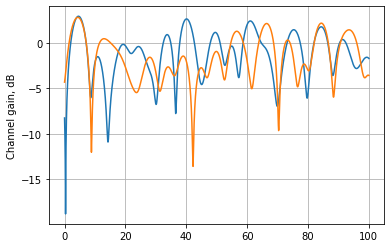

In [3]:
T = 1 # transmission time
f_d = 0.1 # Doppler frequency
n_paths = 100 # The number of paths in Jakes model
n_users = 2  # The number of users in the system
channels = [JakesModel(100, f_d) for i in range(n_users)]


t = np.arange(0, 100, 0.001)

plt.figure()
for i in range(n_users):
    plt.plot(t, 10 * np.log10(np.abs(channels[i].get(t))))
plt.grid()
plt.ylabel('Channel gain, dB')
plt.show()

As one can see, the channel conditions differ for different users. The task of the base station is to perform the scheduling: select a single user and transmit data to it. The performance measure may be:
* the sum data rate
* the worst 10% users data rate

The task for the current assignment is the following
1. Estimate different scheduling strategies: "round robbin" and "best channel conditions"
2. Evaluate the sum spectral efficiency given these two strategies (bit/s/Hz) for different number of users
3. Compare both strategies with the AWGN that has the same time-averaged SNR
4. Evaluate the "fairness" of each scheduling strategy

# Solution

# **Mutual parameters and functions (for "Round Robbin" and "Best Channel Conditions")**

In [3]:
n_experiments = 10  # The number of experiments for statistics
M = 100 # The number of timeslots with length T
T = 1 # Transmission time (timeslot) [sec]
N = 10 # The number of samples per slot (for finding min SNR a slot)
dt = T/N # Sampling period [sec]
B = 1/dt # bandwidth
t = np.arange(0, M, dt) # Time interval expressed in timeslots
n_users = 10  # The number of users in the system

f_d = 0.1 # Doppler frequency [Hz]
n_paths = 100 # The number of paths in Jakes model

def printExperimentInfo():
    print("Experiments:",n_experiments) 
    print("Timeslots:",M)
    print("Timeslot duration, sec:",T)
    print("Samples per slot:",N)
    print("Users:", n_users)
    print()

def printAllresults(): # print the average results of all experiments
    print("1)Sum data   [bit] =        ", AVERAGE_C*M)
    print()
    print("2)Average C  [bit/sec] =    ", AVERAGE_C)
    print()
    print("3)Average SE [bit/sec/Hz]=  ", AVERAGE_SE)
    print()
    print("4)Average Fairness =        ",AVG_Fairness)
    print()

printExperimentInfo() # print info about experiment

def plotRateDistribution(slots,value):
    fig, ax = plt.subplots()
    ax.bar(np.arange(0, slots), value)
    fig.set_figwidth(12)    #  ширина Figure
    fig.set_figheight(4)    #  высота Figure
    plt.grid()
    plt.xlabel('Slot number')
    plt.ylabel('Each slot data rate [bit/sec]')
    plt.show()
    print()

def plotFairDistribution(users,value):
    fig, ax = plt.subplots()
    ax.bar(np.arange(1, users+1), value)
    fig.set_figwidth(12)    #  ширина Figure
    fig.set_figheight(4)    #  высота Figure
    plt.grid()
    plt.xlabel('User')
    plt.ylabel('All time data amount [bit] (shows fairness)')
    plt.show()
    print()

Experiments: 10
Timeslots: 100
Timeslot duration, sec: 1
Samples per slot: 10
Users: 10



# **Fairness metrics**

Define fairness metrics as functions (https://en.wikipedia.org/wiki/Fairness_measure)

Let we have values $x_i$, $i=[1...N]$, where $x_i$ - the amount of resources that was given to the $i$ user.

Jain's fairness index (the simpliest metric)
$$
Fairness(x_1,x_2,...,x_i)=\frac{(\sum_{i=1}^N{x_i})^2}{N{\sum_{i=1}^N{x_i^2}}}
$$

Bossaer's fairness index (more sensetively than Jain's fairness index)
$$
Fairness(x_1,x_2,...,x_i)=\prod_{i=1}^N(\frac{x_i}{max(x_1,x_2,...,x_i)})^{1/k}
$$
$k$ influences on sensitivity (less k => more sensitivity)

Also we can use other metrics...

In [4]:
#Jain's fairness index
def JainFairness(fair_array):
    result = np.sum(fair_array)**2/(fair_array.size*np.sum(fair_array**2)) 
    return result

#Bossaer's fairness index
def BossaerFairness(fair_array):
    k=8 # sensitivity
    result = 1
    for i in range(fair_array.size):
        result = result*(fair_array[i]/np.max(fair_array))**(1/k)
    return result

# **Round Robbin. Many users, many experiments**
# **Total amount of data, time-averaged data rate and spectral efficiency, fairness averaged by number of experiments.  Load distribution by users and by slots**

In this case for each experiment we generate JakesModel, then for each user: calculate SNR, data amount at all time slots in which current user will be active (for ex if we have 3 users, 1st user will be active in 0,3,6,9 slots, 2nd user will be active in 1,4,7,10 etc). Then we calculate sum data amount for all users and for all timeslots, all time data amount, data rate, spectral efficiency and fairness.
Then each metric is averaged over the number of experiments.
Then we print graphs: 1) the amount of data passed through 1 user; 2) the amount of data passed during each slot;

Round Robbin:
Experiments: 10
Timeslots: 100
Timeslot duration, sec: 1
Samples per slot: 10
Users: 10

Experiment 0   SUM_D [bit] = 768.9068525977927
           AVG_C [bit/sec] = 7.689068525977928
       AVG_SE [bit/sec/Hz] = 0.7689068525977929
                   Fairness= 0.9160877620585249

Experiment 1   SUM_D [bit] = 694.896659473502
           AVG_C [bit/sec] = 6.948966594735021
       AVG_SE [bit/sec/Hz] = 0.6948966594735022
                   Fairness= 0.8846644349105394

Experiment 2   SUM_D [bit] = 605.3338286092827
           AVG_C [bit/sec] = 6.053338286092827
       AVG_SE [bit/sec/Hz] = 0.6053338286092829
                   Fairness= 0.9257106346619716

Experiment 3   SUM_D [bit] = 738.746924316592
           AVG_C [bit/sec] = 7.38746924316592
       AVG_SE [bit/sec/Hz] = 0.738746924316592
                   Fairness= 0.9448616502612701

Experiment 4   SUM_D [bit] = 649.9334695129246
           AVG_C [bit/sec] = 6.499334695129246
       AVG_SE [bit/sec/Hz] = 0.649933469512

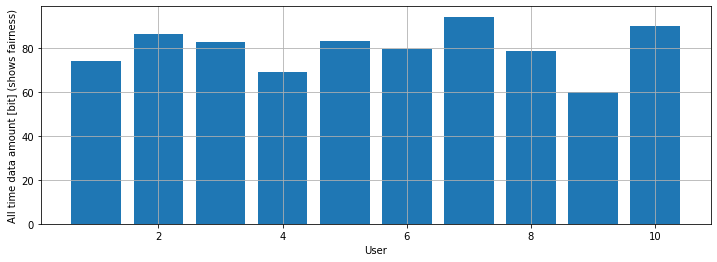

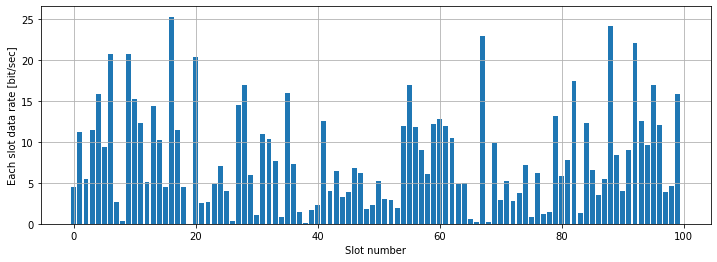

In [5]:
print("Round Robbin:")
printExperimentInfo()

AVERAGE_SE=0
AVERAGE_C=0
AVG_Fairness=0

for k in range(n_experiments): # for each experiment
    RS = np.zeros(M) # data amount array for each slot
    RU = np.zeros(n_users) # data amount array for each user

    # create JakesModel with n_paths sin's and f_d for each of n_experiments
    channels = [JakesModel(n_paths, f_d) for i in range(n_users)]
    
    #plt.figure()
    #plt.grid()
    
    #RoundRobbin
    for i in range(n_users): # for each user: # for each user in current experiment
        #SNRdb = 10 * np.log10(np.abs(channels[i].get(t))) # calculate SNR in dB
        #plt.plot(t, SNRdb)  # plot SNR on graph
        
        SNR = np.abs(channels[i].get(t))**2 # measuring SNR (linear scale) for each time point 
        
        for j in range(i, M, n_users): # during each of M timeslots for user i with step n_users:
            SNR_min = np.min(SNR[j*N:(j+1)*N]) # finding min SNR in current timeslot
            
            # C = B*np.log2(1 + SNR_min) - data rate in each timeslot [bit/sec]; R = B*T*np.log2(1 + SNR_min) -amount of data in each timeslot T [bit]
            # SE = C/B = R/BT = np.log2(1 + SNR_min) -  spectral efficiency
            
            RS[j] = B*T*np.log2(1 + SNR_min)  # counting data amount in all timeslots [bit]
            RU[i] = RU[i] + RS[j] # counting data amount for all users [bit]

    #print("RS=",RS)
    #print("RU=",RU)
    
    C=RS/T # data rate in all timeslots
    SE=RS/(T*B) # spectral efficiency in all timeslots

    SUM_DATA = np.sum(RS) # sum data in current slot for all users
    print("Experiment",k,"  SUM_D [bit] =",SUM_DATA)
    AVG_C = np.mean(C) # average data rate for all users
    print("           AVG_C [bit/sec] =",AVG_C)
    AVG_SE = np.mean(SE) # average spectral efficiency for all users
    print("       AVG_SE [bit/sec/Hz] =",AVG_SE)

    Fairness = JainFairness(RU)
    #Fairness = BossaerFairness(RU)
    print("                   Fairness=",Fairness)
    print()

    AVERAGE_SE=AVERAGE_SE+AVG_SE/n_experiments # calculate Average SE
    AVERAGE_C=AVERAGE_C+AVG_C/n_experiments # calculate Average C
    AVG_Fairness=AVG_Fairness+Fairness/n_experiments # calculate Average fairness using Fairness_array

print("Averaged by n_experiments:")
print("Round Robbin:")
printAllresults()
print()
print("Example for the last experiment only:")
plotFairDistribution(n_users,RU)
plotRateDistribution(M,RS)

# Round Robbin

# Dependence of fairness and data rate on the number of users (same code as previous, but in cycle)

Users = 1   Fairness = 0.980669992250628 Data rate = 7.204519489042203
Users = 2   Fairness = 0.9905865981945398 Data rate = 7.420240445850204
Users = 3   Fairness = 0.9845602980206717 Data rate = 6.812976976191738
Users = 4   Fairness = 0.9727340612874 Data rate = 7.16156489260009
Users = 5   Fairness = 0.9567426412265553 Data rate = 6.867587826104089
Users = 6   Fairness = 0.947689867588736 Data rate = 7.657698184213199
Users = 7   Fairness = 0.945487322806377 Data rate = 7.256508558417498
Users = 8   Fairness = 0.9378331666964632 Data rate = 7.285902278833972
Users = 9   Fairness = 0.9471428062601316 Data rate = 7.272566984761223
Users = 10   Fairness = 0.9325174412441689 Data rate = 6.923302617099731
Users = 11   Fairness = 0.9202147311319006 Data rate = 7.095795823676192
Users = 12   Fairness = 0.9453592983299504 Data rate = 7.2557722565651295
Users = 13   Fairness = 0.9293880331239698 Data rate = 7.195434044916695
Users = 14   Fairness = 0.9265306502384976 Data rate = 6.980612152

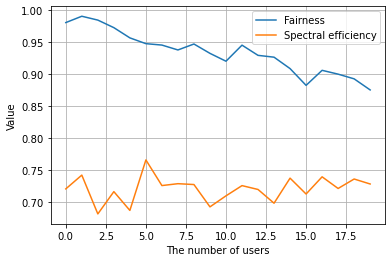

In [6]:
n_users_limit = 20
# this function - same code as previous
def graph(n_users):
    AVERAGE_SE=0
    AVERAGE_C=0
    AVG_Fairness=0

    for k in range(n_experiments): # for each experiment
        RS = np.zeros(M) # data amount array for each slot
        RU = np.zeros(n_users) # data amount array for each user

        # create JakesModel with n_paths sin's and f_d for each of n_experiments
        channels = [JakesModel(n_paths, f_d) for i in range(n_users)]
        
        #plt.figure()
        #plt.grid()
        
        #RoundRobbin
        for i in range(n_users): # for each user: # for each user in current experiment
            
            #SNRdb = 10 * np.log10(np.abs(channels[i].get(t))) # calculate SNR in dB
            #plt.plot(t, SNRdb)  # plot SNR on graph
            
            SNR = np.abs(channels[i].get(t))**2 # measuring SNR (linear scale) for each time point 
            
            for j in range(i, M, n_users): # during each of M timeslots for user i with step n_users
                SNR_min = np.min(SNR[j*N:(j+1)*N]) # find min SNR in current timeslot
                
                # C = B*np.log2(1 + SNR_min) - data rate in each timeslot [bit/sec]; R = B*T*np.log2(1 + SNR_min) -amount of data in each timeslot T [bit]
                # SE = C/B = R/BT = np.log2(1 + SNR_min) -  spectral efficiency
                
                RS[j] = B*T*np.log2(1 + SNR_min)  # counting data amount in all timeslots [bit]
                RU[i] = RU[i] + RS[j] # counting data amount for all users [bit]

        #print("RS=",RS)
        #print("RU=",RU)
        
        C=RS/T # data rate in all timeslots
        SE=RS/(T*B) # spectral efficiency in all timeslots

        SUM_DATA = np.sum(RS) #sum data in current slot for all users
        #print("Experiment",k,"  SUM_D [bit] =",SUM_DATA)
        AVG_C = np.mean(C) # average data rate for all users
        #print("           AVG_C [bit/sec] =",AVG_C)
        AVG_SE = np.mean(SE) # average spectral efficiency for all users
        #print("       AVG_SE [bit/sec/Hz] =",AVG_SE)

        Fairness = JainFairness(RU)
        #Fairness = BossaerFairness(RU)
        #print("                   Fairness=",Fairness)
        #print()

        AVERAGE_SE=AVERAGE_SE+AVG_SE/n_experiments # calculate Average SE
        AVERAGE_C=AVERAGE_C+AVG_C/n_experiments # calculate Average C
        AVG_Fairness=AVG_Fairness+Fairness/n_experiments # calculate Average fairness using Fairness_array
    return AVG_Fairness,AVERAGE_C

fairness=np.zeros(n_users_limit)
datarate=np.zeros(n_users_limit)

# cycle with users
for n_users in range(1,n_users_limit+1):
    FairnessDatarate = graph(n_users + 1)
    fairness[n_users-1]=FairnessDatarate[0]
    datarate[n_users-1]=FairnessDatarate[1]
    print('Users =',n_users,'  Fairness =',FairnessDatarate[0],'Data rate =',FairnessDatarate[1])
#print(fairness)
plt.plot(np.arange(0,n_users_limit,1), fairness,label='Fairness')
plt.plot(np.arange(0,n_users_limit,1), datarate/B,label='Spectral efficiency')
plt.grid()
plt.legend();
plt.xlabel('The number of users')
plt.ylabel('Value')
print()
print("Plot:")

# **Best Channel Conditions. Many users, many experiments**
# **Total amount of data, time-averaged data rate and spectral efficiency, fairness averaged by number of experiments.  Load distribution by users and by slots**

In this case for each experiment we generate JakesModel, then for each timeslot: calculate SNR of all users, choose min SNRs for each user in current timeslot, then choose user with max SNR of min SNRs in current timeslot, then calculate data amount for each (best) user in current timeslot and sum data amount for each user. Then we calculate all time data amount, data rate, spectral efficiency and fairness. Then each metric is averaged over the number of experiments. Then we print graphs: 1) the amount of data passed through 1 user; 2) the amount of data passed during each slot;

Best Channel Conditions:
Experiments: 10
Timeslots: 100
Timeslot duration, sec: 1
Samples per slot: 10
Users: 20

Experiment 0   SUM_D [bit] = 1881.4473186163982
           AVG_C [bit/sec] = 18.814473186163983
       AVG_SE [bit/sec/Hz] = 1.8814473186163978
                   Fairness= 0.6423580093118264

Experiment 1   SUM_D [bit] = 1993.6293128160835
           AVG_C [bit/sec] = 19.936293128160834
       AVG_SE [bit/sec/Hz] = 1.9936293128160834
                   Fairness= 0.7015681201337318

Experiment 2   SUM_D [bit] = 2001.8789300948786
           AVG_C [bit/sec] = 20.018789300948786
       AVG_SE [bit/sec/Hz] = 2.001878930094878
                   Fairness= 0.6493098108618112

Experiment 3   SUM_D [bit] = 2023.7531266060075
           AVG_C [bit/sec] = 20.237531266060074
       AVG_SE [bit/sec/Hz] = 2.023753126606007
                   Fairness= 0.6348704610293838

Experiment 4   SUM_D [bit] = 2136.71516410735
           AVG_C [bit/sec] = 21.3671516410735
       AVG_SE [bit/sec/H

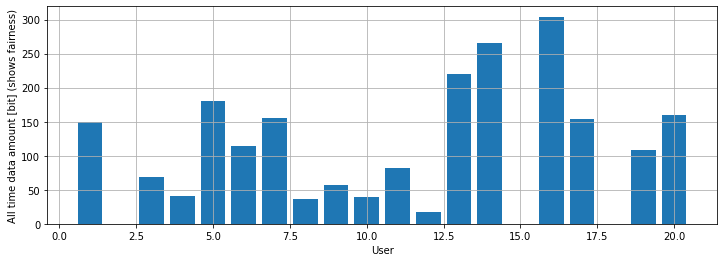

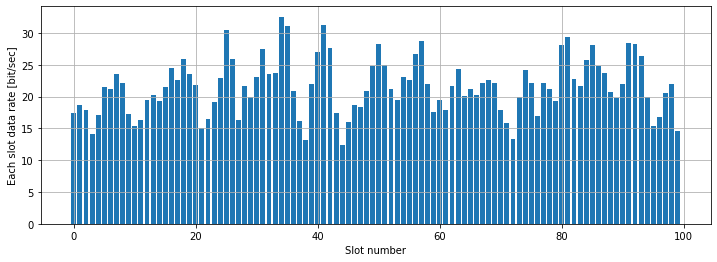

In [7]:
print("Best Channel Conditions:")
printExperimentInfo()

AVERAGE_SE=0
AVERAGE_C=0
AVG_Fairness=0

A=np.zeros([n_users])

for k in range(n_experiments): #for each experiment
    RS = np.zeros(M) # data amount array for each slot
    RU = np.zeros(n_users) # data amount array for each user

    # create JakesModel with n_paths sin's and f_d for each of n_users
    channels = [JakesModel(n_paths, f_d) for i in range(n_users)]
    
    #plt.figure()
    #plt.grid()
    
    #BestBhannelConditions
    #for i in range(n_users): # for each user
        #SNRdb = 10 * np.log10(np.abs(channels[i].get(t))) # calculate SNR in dB
        #plt.plot(t, SNRdb)  # plot SNR on graph

    for j in range(M): # for each of timeslots 
        for i in range(n_users): # for each user (check each user)
            
            SNR = np.abs(channels[i].get(t))**2 # calculate SNR
            SNR_min = np.amin(SNR[j*N:(j+1)*N]) # find min SNR in current timeslot
            A[i]=SNR_min # write this SNR_min in A[i]
            
        #print("A=",A)
        SNR_max_min= np.max(A) # find max SNR among min SNRs in current timeslot (best conditions)
        #print("np.argmax(A)=",np.argmax(A))
        #print("SNR_max_min=",SNR_max_min)
        
        # C = B*np.log2(1 + SNR_min) - data rate in each timeslot [bit/sec]; R = B*T*np.log2(1 + SNR_min) -amount of data in each timeslot T [bit]
        # SE = C/B = R/BT = np.log2(1 + SNR_min) -  spectral efficiency
        
        RS[j] = B*T*np.log2(1 + SNR_max_min)  # counting data amount in all timeslots [bit]
        RU[np.argmax(A)] = RU[np.argmax(A)] + RS[j] # counting data amount for all users [bit]

    #print("RS=",RS)
    #print("RU=",RU)
    
    C=RS/T # data rate in all timeslots
    SE=RS/(T*B) # spectral efficiency in all timeslots

    SUM_DATA = np.sum(RS) #sum data in current slot for all users
    print("Experiment",k,"  SUM_D [bit] =",SUM_DATA)
    AVG_C = np.mean(C) # average data rate for all users
    print("           AVG_C [bit/sec] =",AVG_C)
    AVG_SE = np.mean(SE) # average spectral efficiency for all users
    print("       AVG_SE [bit/sec/Hz] =",AVG_SE)

    Fairness = JainFairness(RU)
    #Fairness = BossaerFairness(RU)
    print("                   Fairness=",Fairness)
    print()

    AVERAGE_SE=AVERAGE_SE+AVG_SE/n_experiments # calculate Average SE
    AVERAGE_C=AVERAGE_C+AVG_C/n_experiments # calculate Average C
    AVG_Fairness=AVG_Fairness+Fairness/n_experiments # calculate Average fairness using Fairness_array

print("Averaged by n_experiments:")
print("Best Channel Conditions:")
printAllresults()
print()
print("Example for the last experiment only:")
plotFairDistribution(n_users,RU)
plotRateDistribution(M,RS)

# Best Channel Conditions

# Dependence of fairness and data rate on the number of users (same code as previous, but in cycle)

Еhis is long running code for a large limit of users and the number of repetitions per point

Users = 1   Fairness = 0.9836697601120683 Data rate = 10.204471023023645
Users = 2   Fairness = 0.9144577800500665 Data rate = 11.881784031046179
Users = 3   Fairness = 0.8956542582203592 Data rate = 13.616835420300049
Users = 4   Fairness = 0.8420903115218324 Data rate = 14.386686650297344
Users = 5   Fairness = 0.8392328784354705 Data rate = 15.03361297118483
Users = 6   Fairness = 0.8367391523315455 Data rate = 15.82166197229389
Users = 7   Fairness = 0.7992172874126054 Data rate = 16.87692253667389
Users = 8   Fairness = 0.8135752045890655 Data rate = 17.229199104073935
Users = 9   Fairness = 0.8131350879763852 Data rate = 17.32520858487116
Users = 10   Fairness = 0.7290351374617009 Data rate = 17.991617268803346
Users = 11   Fairness = 0.7307882379333008 Data rate = 18.20955108068777
Users = 12   Fairness = 0.729596453363591 Data rate = 18.388131349511077
Users = 13   Fairness = 0.7240832307475087 Data rate = 18.79822929913023
Users = 14   Fairness = 0.692390328577888 Data rate = 

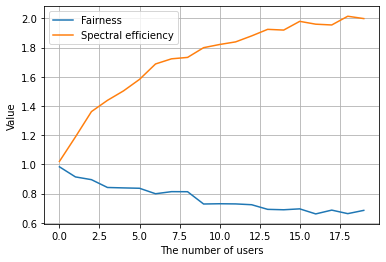

In [8]:
n_users_limit = 20
# this function - same code as previous
def graph1(n_users):

    AVERAGE_SE=0
    AVERAGE_C=0
    AVG_Fairness=0

    A=np.zeros([n_users])

    for k in range(n_experiments): #for each experiment
        RS = np.zeros(M) # data amount array for each slot
        RU = np.zeros(n_users) # data amount array for each user

        # create JakesModel with n_paths sin's and f_d for each of n_users
        channels = [JakesModel(n_paths, f_d) for i in range(n_users)]
        
        #plt.figure()
        #plt.grid()
        
        #BestBhannelConditions
        #for i in range(n_users): # for each user
            #SNRdb = 10 * np.log10(np.abs(channels[i].get(t))) # calculate SNR in dB
            #plt.plot(t, SNRdb)  # plot SNR on graph

        for j in range(M): # for each of timeslots 
            for i in range(n_users): # for each user
                SNR = np.abs(channels[i].get(t))**2 # calculate SNR
                SNR_min = np.amin(SNR[j*N:(j+1)*N]) # find min SNR in current timeslot
                A[i]=SNR_min # write this SNR_min in A[i]
                
            #print("A=",A)  
            SNR_max_min= np.max(A) # find max SNR among min SNRs in current timeslot (best conditions)
            #print("np.argmax(A)=",np.argmax(A))
            #print("SNR_max_min=",SNR_max_min)
            
            # C = B*np.log2(1 + SNR_min) - data rate in each timeslot [bit/sec]; R = B*T*np.log2(1 + SNR_min) -amount of data in each timeslot T [bit]
            # SE = C/B = R/BT = np.log2(1 + SNR_min) -  spectral efficiency
            
            RS[j] = B*T*np.log2(1 + SNR_max_min)  # counting data amount in all timeslots [bit]
            RU[np.argmax(A)] = RU[np.argmax(A)] + RS[j] # counting data amount for all users [bit]

        #print("RS=",RS)
        #print("RU=",RU)
        
        C=RS/T # data rate in all timeslots
        SE=RS/(T*B) # spectral efficiency in all timeslots

        SUM_DATA = np.sum(RS) #sum data in current slot for all users
        #print("Experiment",k,"  SUM_D [bit] =",SUM_DATA)
        AVG_C = np.mean(C) # average data rate for all users
        #print("           AVG_C [bit/sec] =",AVG_C)
        AVG_SE = np.mean(SE) # average spectral efficiency for all users
        #print("       AVG_SE [bit/sec/Hz] =",AVG_SE)

        Fairness = JainFairness(RU)
        #Fairness = BossaerFairness(RU)
        #print("                   Fairness=",Fairness)
        #print()

        AVERAGE_SE=AVERAGE_SE+AVG_SE/n_experiments # calculate Average SE
        AVERAGE_C=AVERAGE_C+AVG_C/n_experiments # calculate Average C
        AVG_Fairness=AVG_Fairness+Fairness/n_experiments # calculate Average fairness using Fairness_array

    return AVG_Fairness,AVERAGE_C

fairness=np.zeros(n_users_limit)
datarate=np.zeros(n_users_limit)

# cycle with users
for n_users in range(1,n_users_limit+1):
    FairnessDatarate = graph1(n_users + 1)
    fairness[n_users-1]=FairnessDatarate[0]
    datarate[n_users-1]=FairnessDatarate[1]
    print('Users =',n_users,'  Fairness =',FairnessDatarate[0],'Data rate =',FairnessDatarate[1])
#print(fairness)
plt.plot(np.arange(0,n_users_limit,1), fairness,label='Fairness')
plt.plot(np.arange(0,n_users_limit,1), datarate/B,label='Spectral efficiency')
plt.grid()
plt.legend();
plt.xlabel('The number of users')
plt.ylabel('Value')
print()
print("Plot:")

# Round Robbin (AWGN). Many users, many experiments

# Total amount of data, time-averaged data rate and spectral efficiency, fairness averaged by number of experiments. Load distribution by users and by slots

# Fix SNR to some value

Round Robbin:
Experiments: 10
Timeslots: 100
Timeslot duration, sec: 1
Samples per slot: 10
Users: 20

Experiment 0   SUM_D [bit] = 1584.9625007211564
           AVG_C [bit/sec] = 15.849625007211564
       AVG_SE [bit/sec/Hz] = 1.5849625007211563
                   Fairness= 1.0000000000000007

Experiment 1   SUM_D [bit] = 1584.9625007211564
           AVG_C [bit/sec] = 15.849625007211564
       AVG_SE [bit/sec/Hz] = 1.5849625007211563
                   Fairness= 1.0000000000000007

Experiment 2   SUM_D [bit] = 1584.9625007211564
           AVG_C [bit/sec] = 15.849625007211564
       AVG_SE [bit/sec/Hz] = 1.5849625007211563
                   Fairness= 1.0000000000000007

Experiment 3   SUM_D [bit] = 1584.9625007211564
           AVG_C [bit/sec] = 15.849625007211564
       AVG_SE [bit/sec/Hz] = 1.5849625007211563
                   Fairness= 1.0000000000000007

Experiment 4   SUM_D [bit] = 1584.9625007211564
           AVG_C [bit/sec] = 15.849625007211564
       AVG_SE [bit/sec/Hz] = 

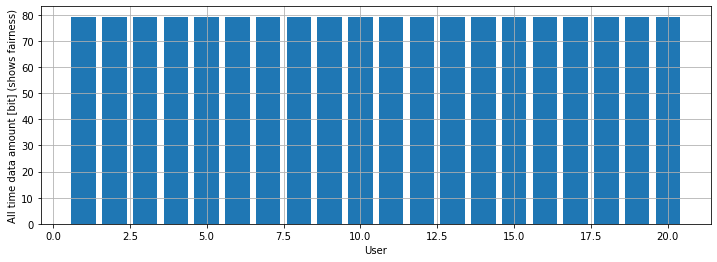

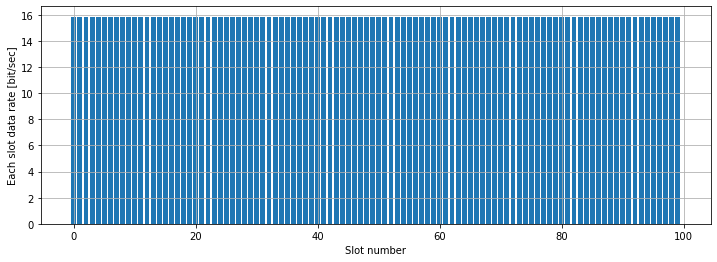

In [9]:
print("Round Robbin:")
printExperimentInfo()

AVERAGE_SE=0
AVERAGE_C=0
AVG_Fairness=0
FixedSNR=2

for k in range(n_experiments): # for each experiment
    RS = np.zeros(M) # data amount array for each slot
    RU = np.zeros(n_users) # data amount array for each user

    # create JakesModel with n_paths sin's and f_d for each of n_experiments
    channels = [JakesModel(n_paths, f_d) for i in range(n_users)]
    
    #RoundRobbin
    for i in range(n_users): # for each user: # for each user in current experiment
        for j in range(i, M, n_users): # during each of M timeslots for user i with step n_users:
            SNR_min = FixedSNR #np.min(SNR[j*N:(j+1)*N]) # finding min SNR in current timeslot
            
            # C = B*np.log2(1 + SNR_min) - data rate in each timeslot [bit/sec]; R = B*T*np.log2(1 + SNR_min) -amount of data in each timeslot T [bit]
            # SE = C/B = R/BT = np.log2(1 + SNR_min) -  spectral efficiency
            
            RS[j] = B*T*np.log2(1 + SNR_min)  # counting data amount in all timeslots [bit]
            RU[i] = RU[i] + RS[j] # counting data amount for all users [bit]

    #print("RS=",RS)
    #print("RU=",RU)
    
    C=RS/T # data rate in all timeslots
    SE=RS/(T*B) # spectral efficiency in all timeslots

    SUM_DATA = np.sum(RS) # sum data in current slot for all users
    print("Experiment",k,"  SUM_D [bit] =",SUM_DATA)
    AVG_C = np.mean(C) # average data rate for all users
    print("           AVG_C [bit/sec] =",AVG_C)
    AVG_SE = np.mean(SE) # average spectral efficiency for all users
    print("       AVG_SE [bit/sec/Hz] =",AVG_SE)

    Fairness = JainFairness(RU)
    #Fairness = BossaerFairness(RU)
    #print("                   Fairness=",Fairness)
    #print()

# Dependence of fairness and data rate on the number of users (same code as previous, but in cycle)ainFairness(RU)
    #Fairness = BossaerFairness(RU)
    print("                   Fairness=",Fairness)
    print()

    AVERAGE_SE=AVERAGE_SE+AVG_SE/n_experiments # calculate Average SE
    AVERAGE_C=AVERAGE_C+AVG_C/n_experiments # calculate Average C
    AVG_Fairness=AVG_Fairness+Fairness/n_experiments # calculate Average fairness using Fairness_array

print("Averaged by n_experiments:")
print("Round Robbin:")
printAllresults()
print()
print("Example for the last experiment only:")
plotFairDistribution(n_users,RU)
plotRateDistribution(M,RS)

# Round Robbin (AWGN)

# Dependence of fairness and data rate on the number of users (same code as previous, but in cycle)

Users = 1   Fairness = 0.9999999999999999 Data rate = 15.849625007211563
Users = 2   Fairness = 0.9998000399920016 Data rate = 15.849625007211563
Users = 3   Fairness = 0.9999999999999999 Data rate = 15.849625007211563
Users = 4   Fairness = 0.9999999999999999 Data rate = 15.849625007211563
Users = 5   Fairness = 0.9992006394884091 Data rate = 15.849625007211563
Users = 6   Fairness = 0.9990009990009989 Data rate = 15.849625007211563
Users = 7   Fairness = 0.9984025559105435 Data rate = 15.849625007211563
Users = 8   Fairness = 0.9992006394884092 Data rate = 15.849625007211563
Users = 9   Fairness = 0.9999999999999999 Data rate = 15.849625007211563
Users = 10   Fairness = 0.9990009990009989 Data rate = 15.849625007211563
Users = 11   Fairness = 0.9968102073365236 Data rate = 15.849625007211563
Users = 12   Fairness = 0.99641291351136 Data rate = 15.849625007211563
Users = 13   Fairness = 0.9976057462090991 Data rate = 15.849625007211563
Users = 14   Fairness = 0.9950248756218907 Data r

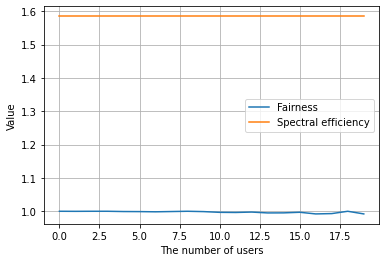

In [10]:
n_users_limit = 20
FixedSNR=2
# this function - same code as previous
def graph(n_users):
    AVERAGE_SE=0
    AVERAGE_C=0
    AVG_Fairness=0

    for k in range(n_experiments): # for each experiment
        RS = np.zeros(M) # data amount array for each slot
        RU = np.zeros(n_users) # data amount array for each user

        # create JakesModel with n_paths sin's and f_d for each of n_experiments
        channels = [JakesModel(n_paths, f_d) for i in range(n_users)]
        
        #RoundRobbin
        for i in range(n_users): # for each user: # for each user in current experiment
            for j in range(i, M, n_users): # during each of M timeslots for user i with step n_users
                SNR_min = FixedSNR#np.min(SNR[j*N:(j+1)*N]) # find min SNR in current timeslot
                
                RS[j] = B*T*np.log2(1 + SNR_min)  # counting data amount in all timeslots [bit]
                RU[i] = RU[i] + RS[j] # counting data amount for all users [bit]

        #print("RS=",RS)
        #print("RU=",RU)
        
        C=RS/T # data rate in all timeslots
        SE=RS/(T*B) # spectral efficiency in all timeslots

        SUM_DATA = np.sum(RS) #sum data in current slot for all users
        #print("Experiment",k,"  SUM_D [bit] =",SUM_DATA)
        AVG_C = np.mean(C) # average data rate for all users
        #print("           AVG_C [bit/sec] =",AVG_C)
        AVG_SE = np.mean(SE) # average spectral efficiency for all users
        #print("       AVG_SE [bit/sec/Hz] =",AVG_SE)

        Fairness = JainFairness(RU)
        #Fairness = BossaerFairness(RU)
        #print("                   Fairness=",Fairness)
        #print()

        AVERAGE_SE=AVERAGE_SE+AVG_SE/n_experiments # calculate Average SE
        AVERAGE_C=AVERAGE_C+AVG_C/n_experiments # calculate Average C
        AVG_Fairness=AVG_Fairness+Fairness/n_experiments # calculate Average fairness using Fairness_array
    return AVG_Fairness,AVERAGE_C

fairness=np.zeros(n_users_limit)
datarate=np.zeros(n_users_limit)

# cycle with users
for n_users in range(1,n_users_limit+1):
    FairnessDatarate = graph(n_users + 1)
    fairness[n_users-1]=FairnessDatarate[0]
    datarate[n_users-1]=FairnessDatarate[1]
    print('Users =',n_users,'  Fairness =',FairnessDatarate[0],'Data rate =',FairnessDatarate[1])
#print(fairness)
plt.plot(np.arange(0,n_users_limit,1), fairness,label='Fairness')
plt.plot(np.arange(0,n_users_limit,1), datarate/B,label='Spectral efficiency')
plt.grid()
plt.legend();
plt.xlabel('The number of users')
plt.ylabel('Value')
print()
print("Plot:")

# **Best Channel Conditions (AWGN). Many users, many experiments**

# **Total amount of data, time-averaged data rate and spectral efficiency, fairness averaged by number of experiments.  Load distribution by users and by slots**

Best Channel Conditions:
Experiments: 10
Timeslots: 100
Timeslot duration, sec: 1
Samples per slot: 10
Users: 20

Experiment 0   SUM_D [bit] = 1584.9625007211564
           AVG_C [bit/sec] = 15.849625007211564
       AVG_SE [bit/sec/Hz] = 1.5849625007211563
                   Fairness= 0.9999999999999998

Experiment 1   SUM_D [bit] = 1584.9625007211564
           AVG_C [bit/sec] = 15.849625007211564
       AVG_SE [bit/sec/Hz] = 1.5849625007211563
                   Fairness= 0.9999999999999998

Experiment 2   SUM_D [bit] = 1584.9625007211564
           AVG_C [bit/sec] = 15.849625007211564
       AVG_SE [bit/sec/Hz] = 1.5849625007211563
                   Fairness= 0.9999999999999998

Experiment 3   SUM_D [bit] = 1584.9625007211564
           AVG_C [bit/sec] = 15.849625007211564
       AVG_SE [bit/sec/Hz] = 1.5849625007211563
                   Fairness= 0.9999999999999998

Experiment 4   SUM_D [bit] = 1584.9625007211564
           AVG_C [bit/sec] = 15.849625007211564
       AVG_SE [bit

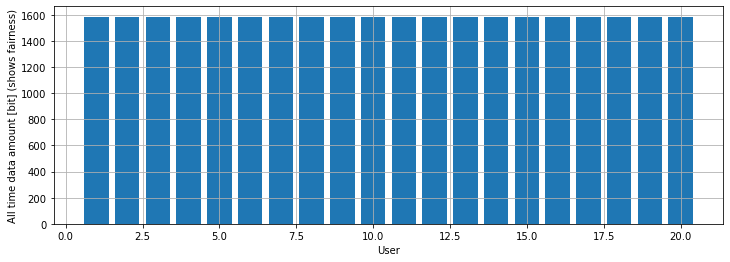

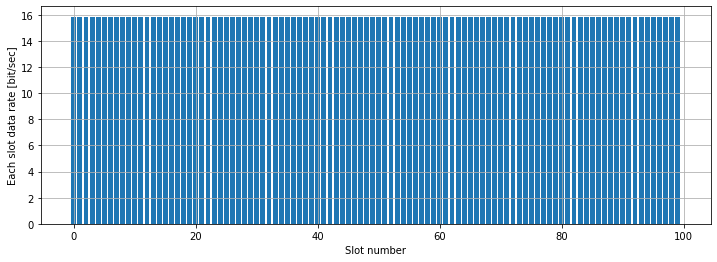

In [11]:
print("Best Channel Conditions:")
printExperimentInfo()

AVERAGE_SE=0
AVERAGE_C=0
AVG_Fairness=0
FixedSNR=2

A=np.zeros([n_users])

for k in range(n_experiments): #for each experiment
    RS = np.zeros(M) # data amount array for each slot
    RU = np.zeros(n_users) # data amount array for each user

    # create JakesModel with n_paths sin's and f_d for each of n_users
    channels = [JakesModel(n_paths, f_d) for i in range(n_users)]
    
    #plt.figure()
    #plt.grid()
    
    #BestBhannelConditions

    for j in range(M): # for each of timeslots 
        for i in range(n_users): # for each user (check each user)
            RS[j] = B*T*np.log2(1 + FixedSNR)  # counting data amount in all timeslots [bit]
            RU[i] = RU[i] + RS[j] # counting data amount for all users [bit]

    #print("RS=",RS)
    #print("RU=",RU)
    
    C=RS/T # data rate in all timeslots
    SE=RS/(T*B) # spectral efficiency in all timeslots

    SUM_DATA = np.sum(RS) #sum data in current slot for all users
    print("Experiment",k,"  SUM_D [bit] =",SUM_DATA)
    AVG_C = np.mean(C) # average data rate for all users
    print("           AVG_C [bit/sec] =",AVG_C)
    AVG_SE = np.mean(SE) # average spectral efficiency for all users
    print("       AVG_SE [bit/sec/Hz] =",AVG_SE)

    Fairness = JainFairness(RU)
    #Fairness = BossaerFairness(RU)
    print("                   Fairness=",Fairness)
    print()

    AVERAGE_SE=AVERAGE_SE+AVG_SE/n_experiments # calculate Average SE
    AVERAGE_C=AVERAGE_C+AVG_C/n_experiments # calculate Average C
    AVG_Fairness=AVG_Fairness+Fairness/n_experiments # calculate Average fairness using Fairness_array

print("Averaged by n_experiments:")
print("Best Channel Conditions:")
printAllresults()
print()
print("Example for the last experiment only:")
plotFairDistribution(n_users,RU)
plotRateDistribution(M,RS)

# Best Channel Conditions (AWGN)

# Dependence of fairness and data rate on the number of users (same code as previous, but in cycle)

Еhis is long running code for a large limit of users and the number of repetitions per point

Users = 1   Fairness = 0.9999999999999999 Data rate = 15.849625007211563
Users = 2   Fairness = 0.9999999999999999 Data rate = 15.849625007211563
Users = 3   Fairness = 0.9999999999999999 Data rate = 15.849625007211563
Users = 4   Fairness = 0.9999999999999999 Data rate = 15.849625007211563
Users = 5   Fairness = 0.9999999999999999 Data rate = 15.849625007211563
Users = 6   Fairness = 1.0 Data rate = 15.849625007211563
Users = 7   Fairness = 0.9999999999999999 Data rate = 15.849625007211563
Users = 8   Fairness = 0.9999999999999999 Data rate = 15.849625007211563
Users = 9   Fairness = 0.9999999999999999 Data rate = 15.849625007211563
Users = 10   Fairness = 1.0 Data rate = 15.849625007211563
Users = 11   Fairness = 0.9999999999999999 Data rate = 15.849625007211563
Users = 12   Fairness = 0.9999999999999997 Data rate = 15.849625007211563
Users = 13   Fairness = 0.9999999999999998 Data rate = 15.849625007211563
Users = 14   Fairness = 0.9999999999999997 Data rate = 15.849625007211563
Use

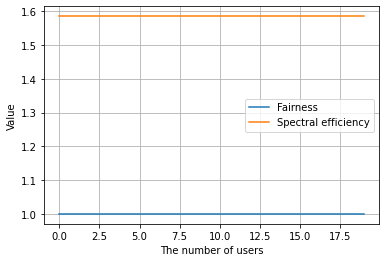

In [12]:
n_users_limit = 20
FixedSNR=2
# this function - same code as previous
def graph1(n_users):

    AVERAGE_SE=0
    AVERAGE_C=0
    AVG_Fairness=0

    A=np.zeros([n_users])

    for k in range(n_experiments): #for each experiment
        RS = np.zeros(M) # data amount array for each slot
        RU = np.zeros(n_users) # data amount array for each user

        # create JakesModel with n_paths sin's and f_d for each of n_users
        channels = [JakesModel(n_paths, f_d) for i in range(n_users)]
        
        #plt.figure()
        #plt.grid()
        
        #BestBhannelConditions
        for j in range(M): # for each of timeslots 
            for i in range(n_users): # for each user
                RS[j] = B*T*np.log2(1 + FixedSNR)  # counting data amount in all timeslots [bit]
                RU[i] = RU[i] + RS[j] # counting data amount for all users [bit]

        #print("RS=",RS)
        #print("RU=",RU)
        
        C=RS/T # data rate in all timeslots
        SE=RS/(T*B) # spectral efficiency in all timeslots

        SUM_DATA = np.sum(RS) #sum data in current slot for all users
        #print("Experiment",k,"  SUM_D [bit] =",SUM_DATA)
        AVG_C = np.mean(C) # average data rate for all users
        #print("           AVG_C [bit/sec] =",AVG_C)
        AVG_SE = np.mean(SE) # average spectral efficiency for all users
        #print("       AVG_SE [bit/sec/Hz] =",AVG_SE)

        Fairness = JainFairness(RU)
        #Fairness = BossaerFairness(RU)
        #print("                   Fairness=",Fairness)
        #print()

        AVERAGE_SE=AVERAGE_SE+AVG_SE/n_experiments # calculate Average SE
        AVERAGE_C=AVERAGE_C+AVG_C/n_experiments # calculate Average C
        AVG_Fairness=AVG_Fairness+Fairness/n_experiments # calculate Average fairness using Fairness_array

    return AVG_Fairness,AVERAGE_C

fairness=np.zeros(n_users_limit)
datarate=np.zeros(n_users_limit)

# cycle with users
for n_users in range(1,n_users_limit+1):
    FairnessDatarate = graph1(n_users + 1)
    fairness[n_users-1]=FairnessDatarate[0]
    datarate[n_users-1]=FairnessDatarate[1]
    print('Users =',n_users,'  Fairness =',FairnessDatarate[0],'Data rate =',FairnessDatarate[1])
#print(fairness)
plt.plot(np.arange(0,n_users_limit,1), fairness,label='Fairness')
plt.plot(np.arange(0,n_users_limit,1), datarate/B,label='Spectral efficiency')
plt.grid()
plt.legend();
plt.xlabel('The number of users')
plt.ylabel('Value')
print()
print("Plot:")

# Summary

As one can see, the RR method provides a slowly decreasing fairness with an increase in the number of users (this is related to the amount of data transferred by each user. The more users, the greater the variation in the amount of data transferred). Moreover, its spectral efficiency fluctuates around a certain constant value, regardless of the number of users.

The ISS method provides fairness, which rapidly decreases with an increase in the number of users (this is due to the fact that competition for transmission increases and there may remain users who did not participate in the transmission of data for the entire period of time under consideration). At the same time, its spectral efficiency is much higher (we choose the best transmission conditions) and has an increasing tendency, which approaches a certain limit (the more users, the greater the choice of transmission conditions in each slot, the probability of occurrence of the best conditions is higher), which is limited by the best transmission conditions among possible in the considered conditions.